In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

# TensorFlow的高层封装TFLearn
learn = tf.contrib.learn
# 神经网络参数
Hidden_size=30
Num_layers=2
timesteps = 10 # 循环神经网络截断长度
Batch_size=32
# 数据参数
training_steps=300
training_examples=1000
testing_examples=100
sample_gap=0.1 # 采样间隔

In [2]:
#输入data
def generate_data(seq):
    # 序列的第i项和后面的TIMESTEPS-1项合在一起作为输入，第i+TIMESTEPS项作为输出
    x=[]
    y=[]
    for i in range(len(seq) - timesteps - 1):
        x.append([seq[i:i+timesteps]])  # seq[1, 9]
        y.append([seq[i+timesteps]])   #seq[10]
    return np.array(x, dtype = np.float32), np.array(y, dtype=np.float32)

In [3]:
# LSTM结构单元
def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(Hidden_size) #??
    return lstm_cell

def lstm_model(x,y):
    # 使用多层LSTM，不能用lstm_cell*NUM_LAYERS的方法，会导致LSTM的tensor名字都一样，深度为Hidden_size
    cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(Num_layers)]) 
    
    # 将多层LSTM结构连接成RNN网络并计算前向传播结果，层数为Num_layers
        # 训练rnn，output为输出的结果，_ 返回的是最终的状态
    output, _ = tf.nn.dynamic_rnn(cell, x, dtype = tf.float32) 
        # 将output 重塑成 n×HIDDEN_SIZE 的矩阵，即每行属于同一层
    output = tf.reshape(output, [-1, Hidden_size])
    
    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构
        # 创建一个全连接层，1 表示输出的维度为1，即做的是 n×HIDDEN_SIZE 的矩阵 和 HIDDEN_SIZE×1的矩阵相乘。
        #None指的是不使用激活函数。
    predictions = tf.contrib.layers.fully_connected(output, 1, None)
    
    # 将predictions和labels调整为统一的shape
    y = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])
    
    # 得到均方损失
    loss = tf.losses.mean_squared_error(predictions, y)
    
    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(loss, tf.train.get_global_step(), optimizer = 'Adagrad', learning_rate = 0.1)
    return predictions, loss, train_op

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c363560b8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model/'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-9600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9600 into model/mod

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1c36358f98>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1c358baef0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


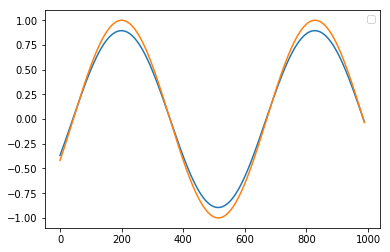

In [7]:
#生成sin 训练和测试数据集
test_start = training_examples*sample_gap # = 1000*0.1 = 100
test_end = (training_examples+testing_examples)*sample_gap # = 1100*0.1 = 110
train_x, train_y = generate_data(np.sin(np.linspace(0, test_start, training_examples, dtype = np.float32))) # linspace得到对应区间上的离散点
test_x, test_y = generate_data(np.sin(np.linspace(test_start, test_end, training_examples, dtype = np.float32)))

# 建立深层循环网络模型
regressor = SKCompat(learn.Estimator(model_fn = lstm_model, model_dir = 'model/'))
# 调用fit函数训练模型
regressor.fit(train_x, train_y, batch_size = Batch_size, steps = training_steps)

# 使用训练好的模型对测试集进行预测
predicted = [[pred] for pred in regressor.predict(test_x)]

# 计算rmse作为评价指标
rmse = np.sqrt(((predicted - test_y)**2).mean(axis=0))
print('Mean Square Error is: %f' % (rmse[0]))

fig = plt.figure()
plot_predicted = plt.plot(predicted, label = 'predicted')
plot_test = plt.plot(test_y, label = 'real_sin')
plt.legend([plot_predicted, plot_test], ['predicted', 'real sin'])
plt.show
fig.savefig('sin.png')